## **Navigating Chemical Structures of Solvents**

t-SNE Tutorial: Organic Solvent Space

By: Ugochukwu M. Ikegwu and Victor M. Zavala

Solvent database was obtained from COSMO-RS (COnductor-like Screening MOdel for Real Solvents) database. 

To access this notebook in Google Colab, please click below:


<a href="https://githubtocolab.com/zavalab/Tutorials/blob/master/CBE660/t-SNE_Solvents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

**t-SNE algorithm as a dimensionality reduction technique for data visualization** 

In chemical engineering, we often deal with multidimensional datasets, including those derived from process monitoring, optimization, molecular simulations, and experimental characterizations. These datasets encompass a wide range of variables, such as temperature, pressure, composition, reaction rates, and molecular descriptors, which can span across various scales and units. The complexity and volume of such data make it challenging to visualize and interpret, necessitating the use of dimensionality reduction techniques like t-SNE to uncover hidden patterns, clusters, or anomalies that might be present.

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a nonlinear technique employed to visualize high-dimensional data by reducing its dimension while preserving the relationships between data points.

At a high level, t-SNE defines two similarity measures between pairs of points: one for the high-dimensional space and another for the 2-dimensional embedding. It then aims to construct a 2D embedding that minimizes the Kullback-Leibler (KL) divergence between these similarity distributions. This non-convex optimization problem is addressed using gradient descent with random initialization, along with techniques like early exaggeration to achieve a reasonable solution.

In simpler terms, t-SNE algorithm follow these steps:


1.   t-SNE looks at how close or far each point is from the others in the high-dimensional space. It does this by calculating the probability that two points are neighbors, based on how far apart they are. Points that are closer together in the high-dimensional space have a higher probability of being neighbors.
2.   t-SNE then tries to arrange these points in a lower-dimensional space (usually 2D) so that the distances between points in this new space reflect the original probabilities.
3.   Finally, t-SNE uses an optimization process to adjust the points in the 2D space until the new arrangement best represents the original relationships.

In this tutorial, we will explore the efficacy of t-SNE in navigating a solvent space.

# *STEP 1: Download solvent database*

In [2]:
!git clone https://github.com/zavalab/Tutorials.git
import os
os.chdir('Tutorials/CBE660/')

Cloning into 'Tutorials'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.(24/41)
remote: Compressing objects: 100% (32/32), done.
remote: Total 41 (delta 14), reused 29 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 3.14 MiB | 6.38 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [4]:
import pandas as pd # This library is used to create and manipulate DataFrames and series.
# For more info on its use and documentation visit https://pandas.pydata.org/
data = pd.read_excel('./Data/Solvents.xlsx')

# *Step 2: Data cleaning*

In [6]:
# Determine the size of the database
size = data.shape
print (f"There are {size[0]} compounds/rows and {size[1]} properties/columns")


There are 1007 compounds/rows and 5 properties/columns


In [7]:
# Eliminate invalid SMILES strings and report the size of the resulting database.
from rdkit import Chem

data['SMILES_Processed'] = data['SMILES'].apply(lambda x: float('nan') if isinstance(Chem.MolFromSmiles(x), type(None)) else x)
data = data[pd.notna(data["SMILES_Processed"])]
data = data.reset_index(drop=True)
new_size = data.shape
print (f"There are {new_size[0]} compounds/rows and {new_size[1]} properties/columns")

There are 1005 compounds/rows and 6 properties/columns


[11:19:55] SMILES Parse Error: extra close parentheses while parsing: O)
[11:19:55] SMILES Parse Error: Failed parsing SMILES 'O)' for input: 'O)'
[11:19:55] SMILES Parse Error: extra close parentheses while parsing: O)
[11:19:55] SMILES Parse Error: Failed parsing SMILES 'O)' for input: 'O)'


In [15]:
# Determine how many unique classes of solvents we have
import numpy as np
solvent_class = []
for i in data["Class"]:
    if i not in solvent_class:
        solvent_class.append(i)
solvent_class.remove(np.nan) # This removes nan for a solvent like water that doesn't have a class
number_of_classes = len(solvent_class)
print (f"There are {number_of_classes} unique solvent classes in the database")

There are 21 unique solvent classes in the database


# *STEP 3a: Explore the database, convert smiles to fingerprints, and visualize the strucutres*

In [ ]:
# Display the names, CAS numbers, SMILES, MF, and structures of 10 randomly-selected solvents.
# More info on the functionalities of rdkit can be found here: https://www.rdkit.org/docs/
import random 
from rdkit.Chem import Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from IPython.display import HTML
import base64
from io import BytesIO

index = random.sample(range(0, len(data)), 10)
mols = [Chem.MolFromSmiles(data['SMILES'][i]) for i in index]

# We can do this using a dataframe
solvents = pd.DataFrame()
solvents['Names'] = [data['Solvent name'][i] for i in index]
solvents['CAS'] = [data['CAS number'][i] for i in index]
solvents['SMILES'] = [data['SMILES'][i] for i in index]
solvents['Molecular Fingerprint'] = [FingerprintMols.FingerprintMol(mol) for mol in mols]

def mol_to_img_str(mol):
    img = Draw.MolToImage(mol, size=(300, 300), kekulize=True)
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return f'<img src="data:image/png;base64,{img_str}"/>'

solvents['Structures'] = [mol_to_img_str(mol) for mol in mols]

,Names,CAS,SMILES,Molecular Fingerprint,Structures
0,Dimethyl Isosorbide,5306-85-4,COC1COC2C1OCC2OC,"[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, ...]",
1,Acetylene (Ethyne),74-86-2,C#C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",
2,"1,9-Nonanediol",3937-56-2,OCCCCCCCCCO,"[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0]",
3,Salicylaldehyde,90-02-8,Oc1ccccc1C=O,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, ...]",
4,Trifluoromethane (Freon 23),75-46-7,FC(F)F,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]",
5,HCFC 225cb,507-55-1,FC(Cl)C(F)(F)C(F)(F)Cl,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, ...]",
6,Diphenyl Acetylene (0 Dipole Moment),501-65-5,c(cc1)ccc1C#Cc2ccccc2,"[0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, ...]",
7,4-Vinyl Pyridine,100-43-6,C=Cc1ccncc1,"[1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...]",
8,4-Aminopyridine,504-24-5,Nc1ccncc1,"[1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, ...]",
9,Fluorene,86-73-7,C(c2cc3)c1ccccc1c2cc3,"[0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, ...]",

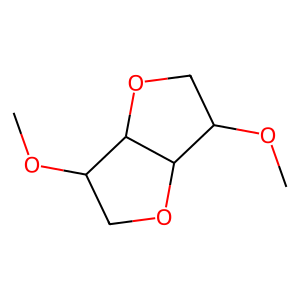
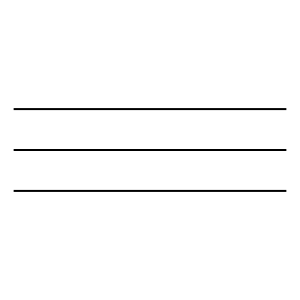
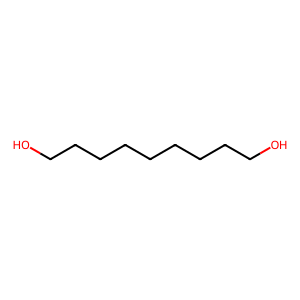
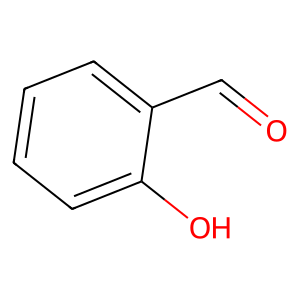
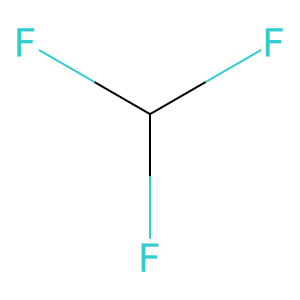
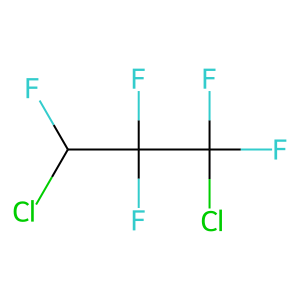
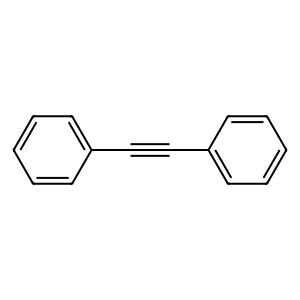
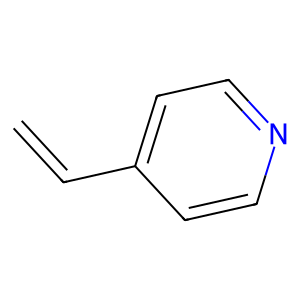
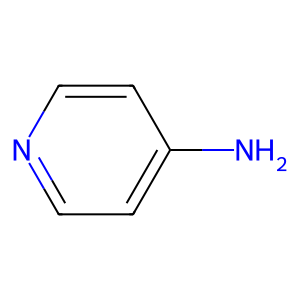
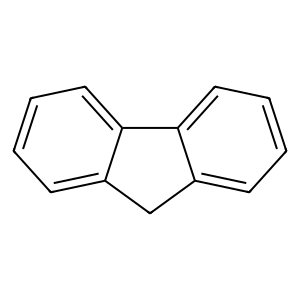

In [33]:
HTML(solvents.to_html(escape=False))

# *STEP 3b: Compute the fingerprints of all solvents*

In [35]:
# Compute the molecular fingerprint of all the solvents
working_library = []
for i in data.index:
    mol = Chem.MolFromSmiles(data.loc[i, "SMILES"]) 
    mol.SetProp('_Name', data.loc[i, "Solvent name"]) 
    working_library.append(mol) 
    
fingerprint = [FingerprintMols.FingerprintMol(mol) for mol in working_library]

# *STEP 4: Compute the similarity matrix using the fingerprints*

As we mentioned at the beginning of this tutorial, t-SNE defines two similarity measures between pairs of points:  one for the **high-dimensional space** and another for the **2-dimensional embedding**.


**High-dimensional Space**

Therefore, first, we need to calculate the **pairwise distances/similarity** to all other points in the high-dimensional space. This is done using the lines of code below.

This step corresponds to calculating the **similarity** between two points *i* and *j* in the high-dimensional space. Here, you're computing how similar two molecules are based on their fingerprints.

In [36]:
# Compute the similarity indices for the entire dataset
from rdkit import DataStructs

size = len(working_library)
similarity_array_mfp = np.zeros((size,size))
for index, i in enumerate(fingerprint):
    for jndex, j in enumerate(fingerprint):
        similarity_index_mfp = DataStructs.FingerprintSimilarity(i,j)
        similarity_array_mfp[index, jndex] = similarity_index_mfp
similarity_table_mfp = pd.DataFrame(similarity_array_mfp, columns=[working_library[j].GetProp('_Name') for j in range(size)])
similarity_table_mfp.index = [working_library[i].GetProp('_Name') for i in range(size)]

In [43]:
# Compute the similarity indices for the 10 randomly-selected solvents

similarity_array_10 = np.zeros((10,10))
for index, i in enumerate(solvents['Molecular Fingerprint']):
    for jndex, j in enumerate(solvents['Molecular Fingerprint']):
        similarity_index_10 = DataStructs.FingerprintSimilarity(i,j)
        similarity_array_10[index, jndex] = similarity_index_10
similarity_table_10 = pd.DataFrame(similarity_array_10, columns=[i for i in solvents['Names']])
similarity_table_10.index = [i for i in solvents['Names']]

# *STEP 5: Visualize the similarity matrix of some solvents*

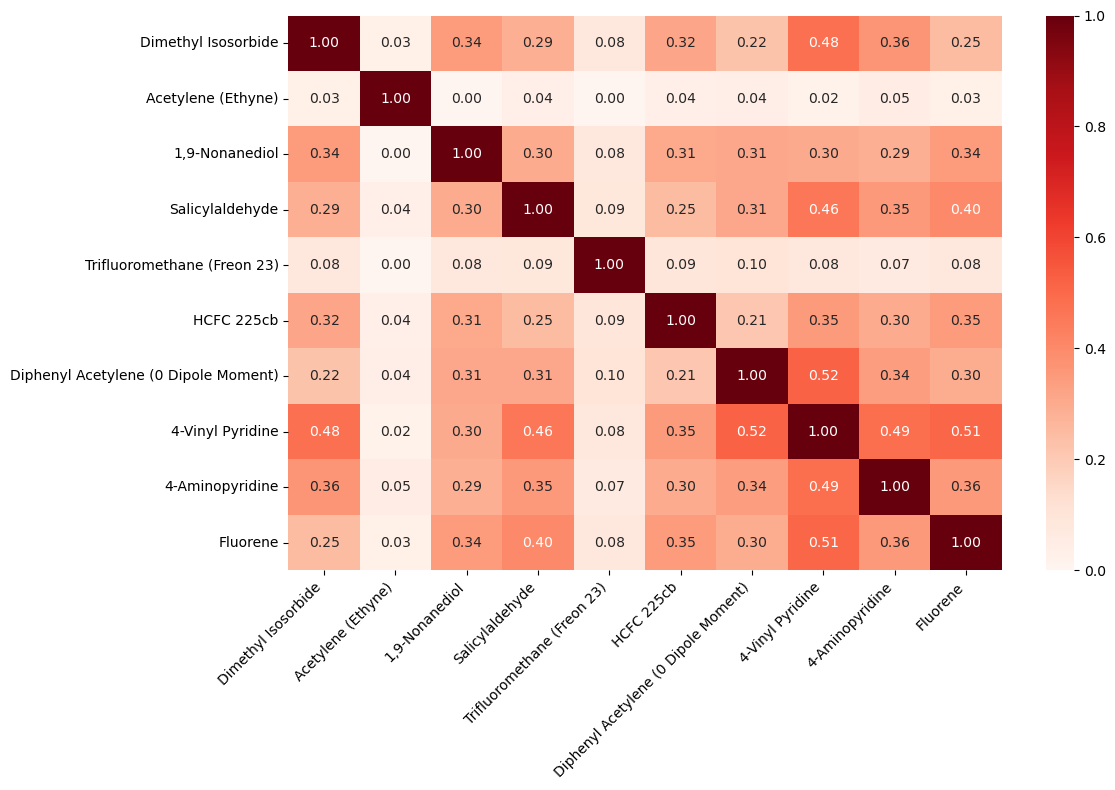

In [46]:
# Visualize the similarities as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['font.size'] = 10
sns.heatmap(similarity_table_10, cmap='Reds', annot=True, fmt=".2f")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()

# *STEP 6a: Perform t-SNE*

In [ ]:
# Perform t-SNE on all the solvents
from sklearn.manifold import TSNE

n_components = 2 # This is the required number of dimensions we seek to reduce out dataset to. 
init = 'pca' # This is used to determine the initialization method for the low-dimensional embedding. 
# pca means that t-SNE will use the first two principal components of the data as the starting point for the optimization. This often leads to faster convergence. 
random_state = 42 # This ensure the reproducibility of our result. Any value can be used
angle = 0.3 # This controls the trade-off between speed and accuracy in the Barnes-Hut approximation used for t-SNE. Values closer to 0 leads to high accuracy but slower speed and vice-versa. 
learning_rate = 50 # This determines the step size in the optimization process. If too high, the algorithm might overshoot the optimal solution; if too low, the convergence will be slow. 
perplexity = 80 # Perplexity is a key hyperparameter in t-SNE that influences how the algorithm balances local and global aspects of the data. 

# Although there isn't a common way of determining the best sets of hyperparameters, silhouette_score can often be used to numerically identify the best values for each hyperparamter. 
# To learn more about silhouette_score visit https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

tsne_mfp = TSNE(n_components=n_components,init=init, random_state=random_state, angle=angle, learning_rate=learning_rate, perplexity=perplexity)
similarity_matrix_mfp = similarity_table_mfp.iloc[0:,0:].values

**The t-SNE algorithm**

The TSNE python module makes it possible to carryout this analysis efficiently. However, this is what goes on behind the scenes. 


1.  High-Dimensional Probabilities: Havind calculated the pairwise similarities in the high-dimensional space, t-SNE converts these into conditional probabilities that reflect the likelihood of one point being a neighbor of another.

2.  Low-Dimensional Probabilities: As the algorithm iteratively adjusts the positions of points in the low-dimensional space (2D), it also calculates analogous probabilities in this space, reflecting the likelihood of points being neighbors in the reduced dimensionality.

3.  KL Divergence: As earlier mentioned, t-SNE algorithm uses the KL divergence as a cost function to measure how different the low-dimensional probability distribution is from the high-dimensional one.

4.  Optimization: The algorithm then iteratively adjusts the positions of the points in the low-dimensional space to minimize the KL divergence. The goal here is to make the low-dimensional probability distribution as similar as possible to the high-dimensional one, thereby preserving the global pairwise similarities.

The line of code below performs this task.

In [ ]:
reduced_data_mfp = tsne_mfp.fit_transform(similarity_matrix_mfp)

# *STEP 6b: Visualize the t-SNE plot (i.e., the latent space)*

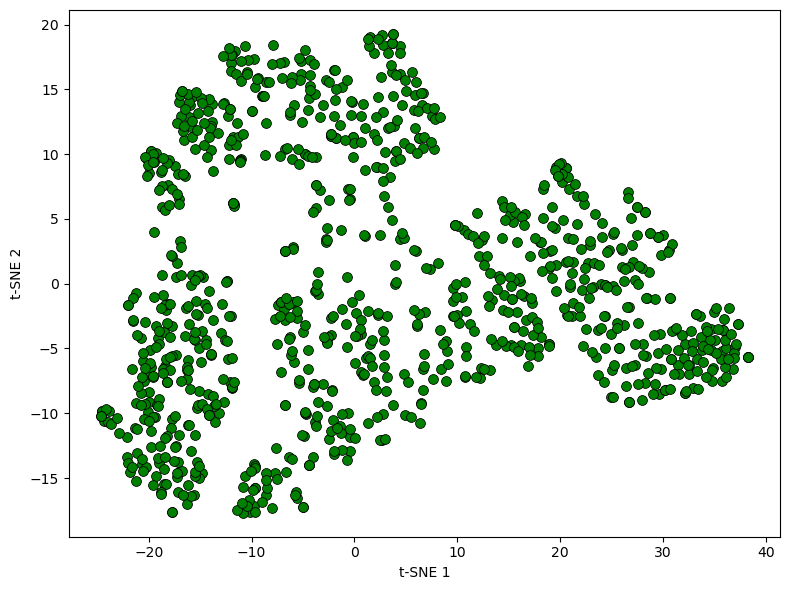

In [52]:
# Visualize all the solvents in a 2D plot
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.scatterplot(x=reduced_data_mfp[:,0], y=reduced_data_mfp[:,1], s= 50, color='g', edgecolor='k')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()

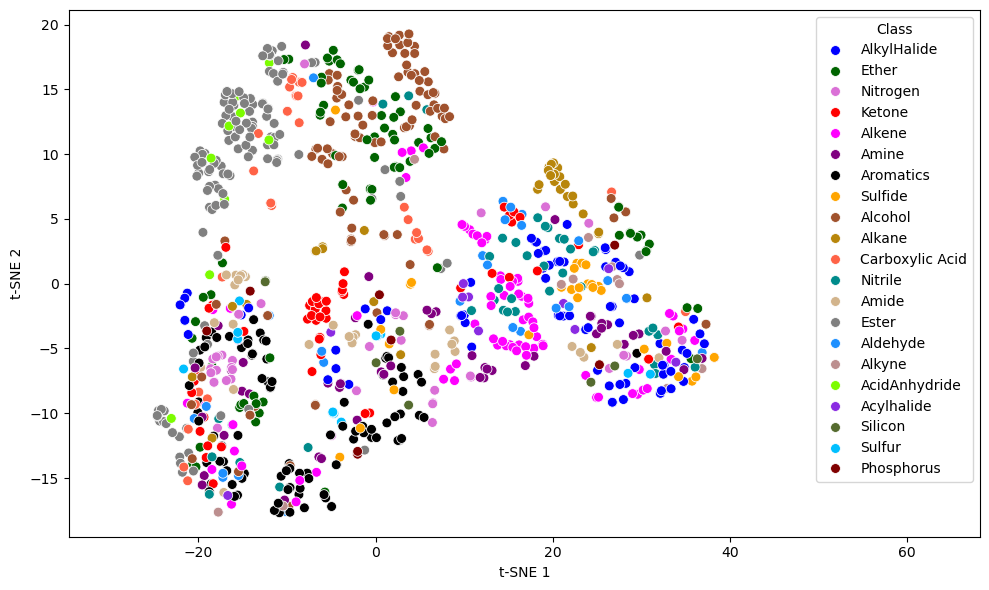

In [63]:
# Color code all the solvents based on the solvent classes 

data['t-SNE 1'] = reduced_data_mfp[:,0]
data['t-SNE 2'] = reduced_data_mfp[:,1]

colors = ['blue','darkgreen','orchid','red','magenta','purple','black','orange','sienna', 'darkgoldenrod',
            'tomato','darkcyan','tan','grey','dodgerblue','rosybrown','lawngreen','blueviolet','darkolivegreen','deepskyblue',
            'maroon']
color_mapping = dict(zip(solvent_class, colors))
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.scatterplot(x=data['t-SNE 1'], y=data['t-SNE 2'], s= 50, hue=data['Class'], palette=color_mapping, data=data, legend='full')
plt.xlim(left=data['t-SNE 1'].min() - 10, right=data['t-SNE 1'].max() + 30)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()


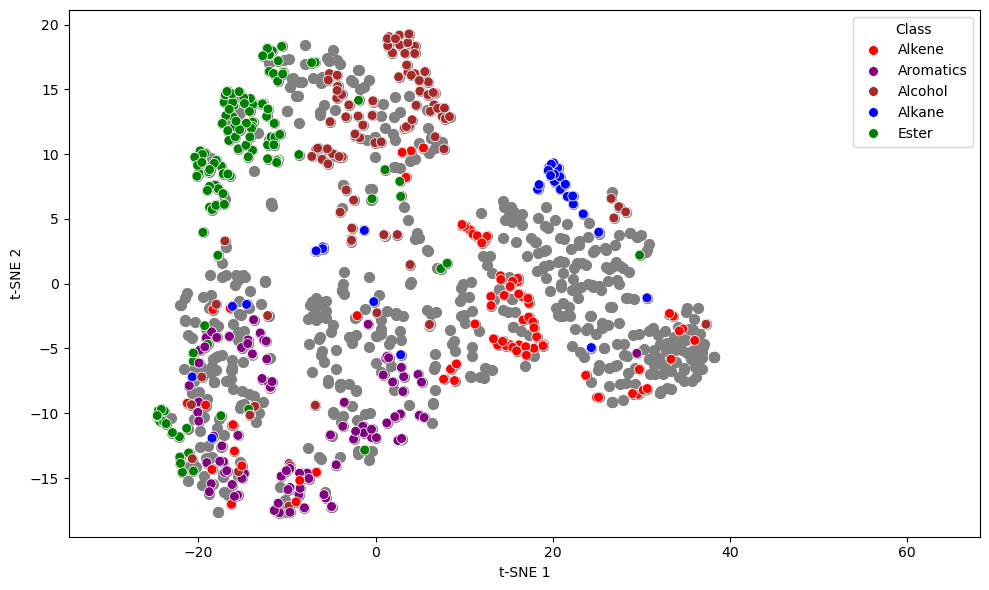

In [76]:
# Color code Alkanes, Alkene, Aromatics, Alcohols, and Esters
colors = ['blue','red','purple','brown','green']
solv_class = ['Alkane', 'Alkene', 'Aromatics', 'Alcohol', 'Ester']
color_mapping = dict(zip(solv_class, colors))
select_data = data[data['Class'].isin(solv_class)]

fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(data['t-SNE 1'], data['t-SNE 2'], s=50, color='grey')
ax = sns.scatterplot(x=select_data['t-SNE 1'], y=select_data['t-SNE 2'], s= 50, hue=select_data['Class'], palette=color_mapping, data=select_data, legend='full')
plt.xlim(left=data['t-SNE 1'].min() - 10, right=data['t-SNE 1'].max() + 30)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()

# *STEP 7a: Kmeans clustering*

Let us explore Kmeans clustering!

As earlier said, K-means clustering is used to cluster points based on the pre-defined number of clusters. It does this by finding cluster centers (centroids) and assigning each data point to the nearest centroid, aiming to minimize the distance between data points and their cluster's center. 
An elbow plot or Silhouette method is used to determined the optimal number of clusters to use.

To read more on K-means visit: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

To read more about elbow plot or Silhouette visit: https://builtin.com/data-science/elbow-method

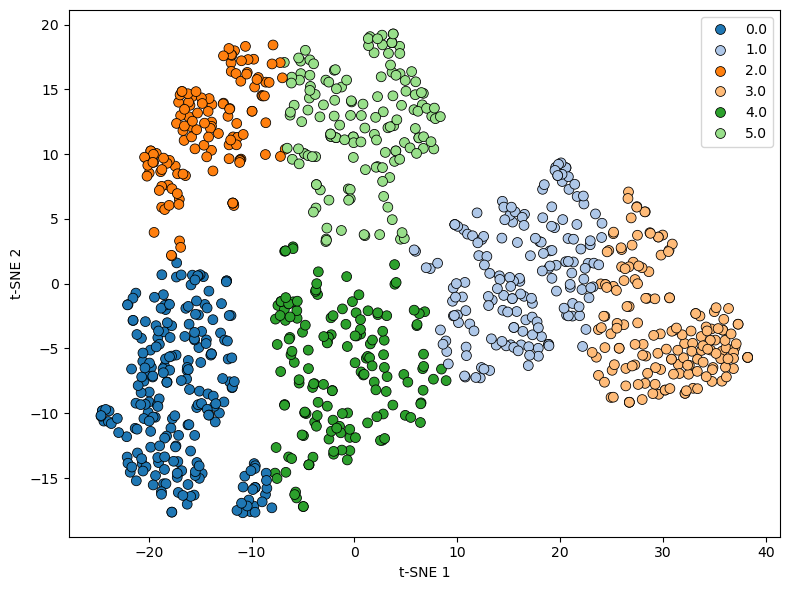

In [ ]:
# Use K-means clustering to identify 6 major clusters of solvents and visualize it
from sklearn.cluster import KMeans

n_clusters = 6 # The model will divide the data into 6 clusters.
n_init = 6 # The algorithm will run 10 times with different starting points for the centroids and pick the best result.
random_state = 42 # Ensures the results are reproducible by using the same random seed.

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
clusters = kmeans.fit_predict(reduced_data_mfp)
clustered_data = np.hstack([reduced_data_mfp,clusters[:,np.newaxis]])

fig, ax = plt.subplots(figsize=(8,6))
ax = sns.scatterplot(x=clustered_data[:,0], y=clustered_data[:,1], hue=clustered_data[:,2], s= 50, palette=sns.color_palette("tab20", n_colors=6), edgecolor='k', legend=True)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()

In [107]:
# Display the molecular structure of a solvent from each cluster. 
data['MOL'] = working_library
data['Clusters'] = clustered_data[:,2]
cluster_0 = data[data['Clusters']==0].reset_index(drop=True)
cluster_1 = data[data['Clusters']==1].reset_index(drop=True)
cluster_2 = data[data['Clusters']==2].reset_index(drop=True)
cluster_3 = data[data['Clusters']==3].reset_index(drop=True)
cluster_4 = data[data['Clusters']==4].reset_index(drop=True)
cluster_5 = data[data['Clusters']==5].reset_index(drop=True)

# *STEP 7b: Further analyses of each cluster*

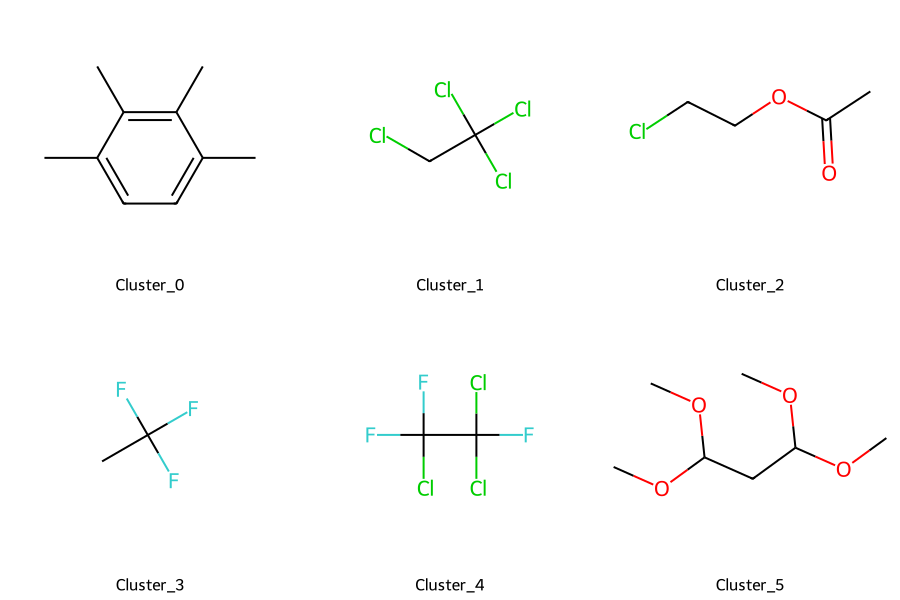

In [108]:
# Visualize some structures across clusters
mols = [cluster_0['MOL'][0], cluster_1['MOL'][0], cluster_2['MOL'][0], cluster_3['MOL'][0], cluster_4['MOL'][0], cluster_5['MOL'][0]]
substructures = []
legends = []
for index in range(len(mols)):
    legends.append(f"Cluster_{index}")

Draw.MolsToGridImage(mols, legends=legends, molsPerRow=3, subImgSize=(300, 300), useSVG=False)

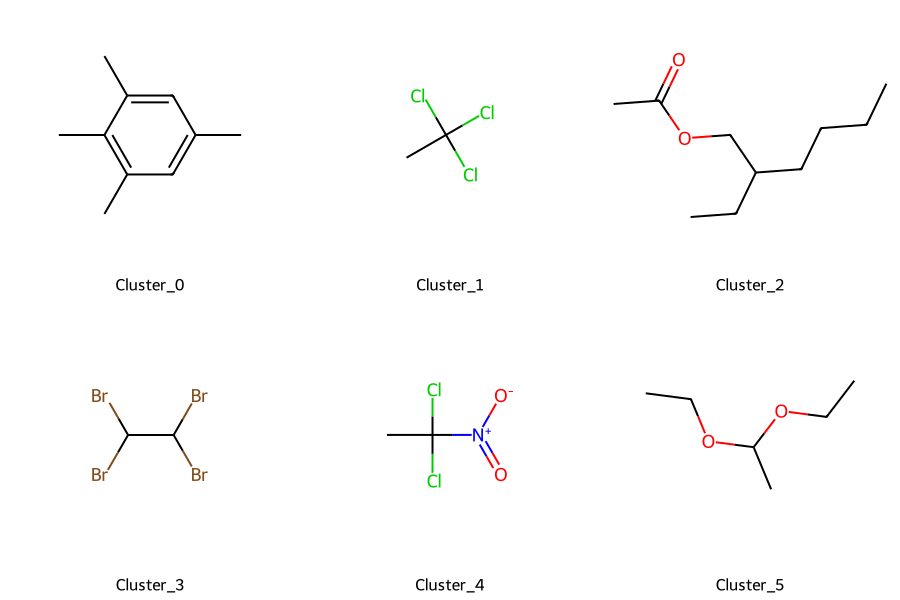

In [109]:
# Visualize some structures across clusters
mols = [cluster_0['MOL'][1], cluster_1['MOL'][1], cluster_2['MOL'][1], cluster_3['MOL'][1], cluster_4['MOL'][1], cluster_5['MOL'][1]]
substructures = []
legends = []
for index in range(len(mols)):
    legends.append(f"Cluster_{index}")

Draw.MolsToGridImage(mols, legends=legends, molsPerRow=3, subImgSize=(300, 300), useSVG=False)